In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
import glob

In [3]:
base_dir = '../input/breast-histopathology-images/*/'
file=os.listdir('../input/breast-histopathology-images')
print(len(file))

280


In [4]:
file[:5]

['10295', '10304', '12868', '10274', '12818']

In [5]:
patient_list = list(glob.glob(base_dir))
print('Number of the patient :'+' '+str(len(patient_list)))

Number of the patient : 280


In [6]:
test=[glob.glob(patient_list[i]+'/*/*') for i in range(0,len(patient_list))]

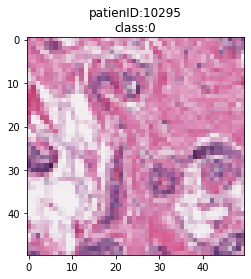

In [7]:
from skimage import io
img_sample = io.imread(test[0][0])
plt.title('patienID:'
          +str(test[0][0].split('/')[3])+'\n'
         'class:'+str(test[0][0].split('/')[4]))
plt.imshow(img_sample)

In [8]:
patient_ID = [test[i][x].split('/')[3]for i in range(0,len(test))for x in range(0,len(test[i]))]
class_test = [test[i][x].split('/')[4]for i in range(0,len(test))for x in range(0 ,len(test[i]))]
patient_pathes = [test[i][x]for i in range(0,len(test))for x in range(0,len(test[i]))]

In [13]:
d = {'patient_ID':patient_ID,'pathes':patient_pathes,'diagnosis':class_test}

import dask.dataframe as dd
df = pd.DataFrame(d)

In [14]:
# df.to_csv('Breast Cancer dataset.csv',index=False)
# df=pd.read_csv('./Breast Cancer dataset.csv',low_memory=False)

In [15]:
df_new = df.iloc[:10000,:]

In [16]:
from PIL.Image import open
df_new['pixels'] =  df_new['pathes'].map(lambda x:np.asarray(open(x).resize((128,128))))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
X = df_new['pixels']
y =  np.array(df_new['diagnosis'])

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [19]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8000,), (2000,), (8000,), (2000,))

In [35]:
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input

train_img = []
for i in range (0,len(X_train)):
    brain_img =np.array(X_train)[i]
    img_arr = image.img_to_array(brain_img).astype(np.float32)
    #train_img.append(img_arr/255)
    train_img.append(preprocess_input(img_arr))
X_scaled = np.array(train_img)

print(X_scaled.shape)


(8000, 128, 128, 3)


In [36]:
X_train_shape = X_scaled.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten = X_scaled.reshape(X_scaled.shape[0],X_train_shape)

## Since imbalance class therefore sampling

In [37]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=10)
X_sm,y_sm = sm.fit_resample(X_Flatten,y_train)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

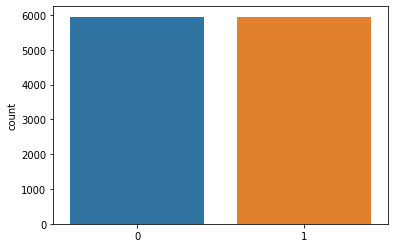

In [38]:
sns.countplot(y_sm )

In [39]:
row,col,channel = 128 ,128 , 3 
X_sm_reshaped = X_sm.reshape(len(X_sm),row,col,channel)

print(X_sm_reshaped.shape)
print(y_sm.shape)

(11906, 128, 128, 3)
(11906,)


In [40]:
from tensorflow import keras
from tensorflow.keras import layers



# model = keras.Sequential()
# model.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(128,128,3)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.25))
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))



In [49]:
from keras.applications import MobileNetV2
num_classes = 1
model = keras.Sequential([
     MobileNetV2(input_shape=(128,128,3),weights=None,include_top=False), 
     layers.GlobalAveragePooling2D(),
     layers.Dense(num_classes, activation='sigmoid',name='preds'),
])
model.layers[0].trainable= False
# show model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd',
             loss=keras.losses.binary_crossentropy,
             metrics=['accuracy'])
model.fit(X_sm_reshaped,y_sm
          ,epochs=20,
          verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model's Training & Validation accuracy across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
img_test = []
for i in range (0,len(X_test)):
    brain_img_test =np.array(X_test)[i]
    img_test_arr = image.img_to_array(brain_img_test).astype(np.float32)
    img_test.append(img_test_arr/255)
X_scaled_test = np.array(img_test)

print(X_scaled_test.shape)

In [76]:
eval_score = model.evaluate(X_scaled_test,y_test)
print('The loss of the evaluation :'+' '+str(eval_score[0]*100))
print('The accuracy of the evaluation :'+' '+str(eval_score[1]*100))

NameError: name 'model' is not defined

In [ ]:

from sklearn.metrics import classification_report , confusion_matrix
y_pred = model.predict_classes(X_scaled_test)
y_pred


In [ ]:
target_name = ['benign','malignant']
classification_report(y_true=y_test , y_pred=y_pred , output_dict=True , target_names= target_name )

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),annot=True , fmt='2d')
plt.title('Confusion Metrix',fontsize=30)
plt.xlabel('Prediction Label',fontsize=20)
plt.ylabel('True Label',fontsize=20)